# Daria Morgan

# The goal of this project is: 
##### To get an idea which brans are more susceptible to the risk of counterfeiting and gray market selling and what factors increase the risk of becoming a target of gray market sellers.
##### (Please, find a separate supplementary jupyter notebook with the code for ScatterText)

# Methodology:

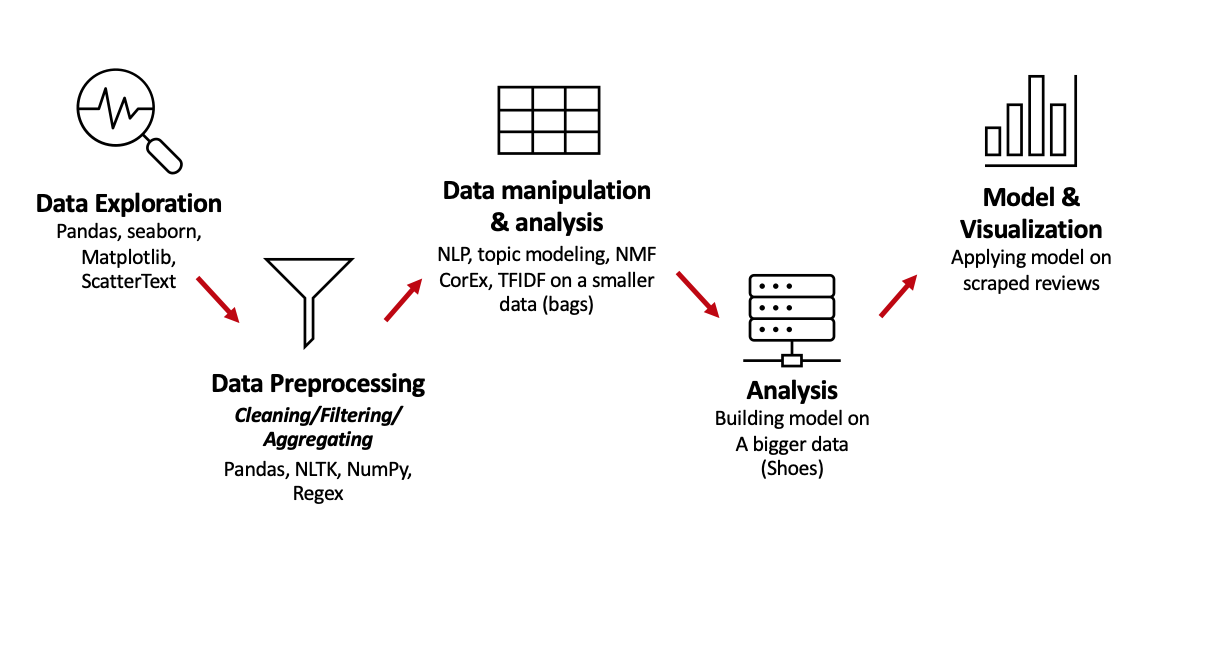

# Notebook navigation:

### [Exploratory analysis:](#Exploratory-analysis)
- Tag reviews that they have a few obvious words such as 'fake', 'fraud', or 'counterfeit' to find which products / categories have signs of clear fraud (before diving deeper with NLP)

### [NLP/topic modeling/text pre-processing steps:](#NLP/topic-modeling/text-pre-processing-steps)
- [First model: NMF](#First-model:-NMF)
- [CorEx on a smaller data (bags category)](#CorEx-on-a-smaller-data-(bags-category))
- [CorEx second iteration](#CorEx-second-iteration)
- [Visualizing topics with t-distributed Stochastic Neighbor Embedding:](#Visualizing-topics-with-t-distributed-Stochastic-Neighbor-Embedding)

### [Larger category modeling (Shoes):](#Larger-category-modeling-(Shoes))
- [CorEx](#CorEx)
- [Visualizing topics with t-distributed Stochastic Neighbor Embedding](#Visualizing-topics-with-t-distributed-Stochastic-Neighbor-Embedding)
- [ Nike (applying model on reviews that were after original data period)](#Nike-(applying-model-on-reviews-that-were-after-original-data-period))

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_pickle('counter_dataset')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359069 entries, 0 to 359068
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   asin                        359069 non-null  object 
 1   review_post_id              359069 non-null  object 
 2   body                        358798 non-null  object 
 3   review_text                 359069 non-null  object 
 4   helpful_count               359069 non-null  int64  
 5   num_images                  359069 non-null  int64  
 6   rating                      359069 non-null  int64  
 7   date_posted                 359069 non-null  object 
 8   is_verified_purchase        359069 non-null  bool   
 9   is_vine_voice               359069 non-null  bool   
 10  num_comments                359069 non-null  int64  
 11  has_video                   359069 non-null  bool   
 12  category                    359069 non-null  object 
 13  list_price    

In [11]:
print("There are",round(100*len(df[df['body'].isnull()])/df.shape[0],2),"% of null reviews (reviews where text is missing)")

There are 0.08 % of null reviews (reviews where text is missing)


In [17]:
df[df['body'].isnull()].category.value_counts(normalize=True)

Men's Shoes         0.380074
Women's Shoes       0.287823
Men's Clothing      0.088561
MakeUp              0.062731
SkinCare            0.051661
Women's Clothing    0.051661
Men's Watches       0.044280
Headphones          0.018450
Women's Handbags    0.007380
Women's Watches     0.007380
Name: category, dtype: float64

In [18]:
df[df['body'].isnull()].rating.value_counts(normalize=True)

5    0.715867
4    0.129151
1    0.129151
2    0.022140
3    0.003690
Name: rating, dtype: float64

Missing reviews are less than 1% across each category and across rating.<br> Given that missing values are only a fraction from the whole data I will drop these values

In [19]:
# drop Null values

df.dropna(subset=['body'], inplace=True)

# Exploratory analysis

### Tag reviews that have a few obvious words such as 'fake', 'fraud', or 'counterfeit' to find which products / categories have signs of clear fraud (before diving deeper with NLP)

I start with a quick exploratory analysis to see if I could find any trends in the reviews by filtering them with a few words that would indicate if a customer mentioned that a product was fake or counterfeit.

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [21]:
def RedFlagWords(text):
    
    '''This function tests whether a review's text has any flag of obvious (fraud) words'''
    
    import re
    text = text.lower()
    flag_words = re.compile('fak|knock|fraud|counterfeit')
    if not re.search(flag_words,text):
        return False
    return True

In [22]:
df['Flag_fraud_words'] = df['body'].apply(RedFlagWords)

In [23]:
df.columns

Index(['asin', 'review_post_id', 'body', 'review_text', 'helpful_count',
       'num_images', 'rating', 'date_posted', 'is_verified_purchase',
       'is_vine_voice', 'num_comments', 'has_video', 'category', 'list_price',
       'price_low', 'price_high', 'is_add_on', 'is_prime', 'is_prime_pantry',
       'is_prime_exclusive', 'is_fresh', 'has_sns', 'offer_fulfiller',
       'offer_merchant', 'lowest_price_new_condition', 'brand', 'num_reviews',
       'num_images_pdp', 'Flag_fraud_words'],
      dtype='object')

In [651]:
(print("There are",sum(df['Flag_fraud_words'])," out of",df.shape[0],
       "that were Flaged as having any mentionings of 'fraud', 'fake', or 'counterfeit'"))

There are 2873  out of 358798 that were Flaged as having any mentionings of 'fraud', 'fake', or 'counterfeit'


My next step is to find the proportion of reviews that mention that the product is fake by each category.

In [29]:
# Find how many reviews there are by category, and how many of them had 'fake' mentions

flag_fruad_cat = (df.groupby(['category'])
                  .agg(review_counts=('review_post_id', 'count'), review_fraud=('Flag_fraud_words', 'sum')).reset_index())

In [30]:
flag_fruad_cat

,category,review_counts,review_fraud
0,Hair Care,9421,57.0
1,Headphones,8901,98.0
2,MakeUp,30757,441.0
3,Men's Clothing,35753,394.0
4,Men's Shoes,90206,686.0
5,Men's Watches,4176,54.0
6,SkinCare,95187,454.0
7,Women's Clothing,18451,146.0
8,Women's Handbags,1676,62.0
9,Women's Shoes,62859,467.0


In [31]:
# find the percentage of clearly "fake" reviews by category

flag_fruad_cat['percentage'] = 100*round(flag_fruad_cat['review_fraud']/flag_fruad_cat['review_counts'],4)

In [32]:
flag_fruad_cat = flag_fruad_cat.sort_values('percentage', ascending=False).reset_index().drop(columns=['index'])

In [33]:
flag_fruad_cat

,category,review_counts,review_fraud,percentage
0,Women's Handbags,1676,62.0,3.70
1,MakeUp,30757,441.0,1.43
2,Men's Watches,4176,54.0,1.29
3,Headphones,8901,98.0,1.10
4,Men's Clothing,35753,394.0,1.10
5,Women's Watches,1411,14.0,0.99
6,Women's Clothing,18451,146.0,0.79
7,Men's Shoes,90206,686.0,0.76
8,Women's Shoes,62859,467.0,0.74
9,Hair Care,9421,57.0,0.61


In a rough estimate "Women's Handbags" category has more mentiones of fraud.  

Next, I want to see which brands within "Women's Handbags" category are more susceptible to counterfeiting by finding a percentage of reviews with fake mentions to all reviews within each brand.

**Percentage of fraud found within "Women's Handbags" category**

In [34]:
# finding number of reviews within each brand, and number of reviews with 'fake' flagged

flag_women_bag_cat = (df[df['category'] == "Women's Handbags"].groupby(['brand'])
                      .agg(review_counts=('review_post_id', 'count'), review_fraud=('Flag_fraud_words', 'sum')).reset_index())

In [35]:
flag_women_bag_cat

,brand,review_counts,review_fraud
0,BURBERRY,90,21.0
1,Calvin,52,0.0
2,Coach,350,10.0
3,Dior,38,0.0
4,Fendi,10,4.0
5,GUESS Factory,15,0.0
6,Gucci,9,0.0
7,JIMMY CHOO,2,0.0
8,Kate,177,1.0
9,Louis Vuitton,11,5.0


In [36]:
# finding the percentage

flag_women_bag_cat['percentage'] = 100*round(flag_women_bag_cat['review_fraud']/flag_women_bag_cat['review_counts'],4)

In [37]:
flag_women_bag_cat = flag_women_bag_cat.sort_values('percentage', ascending=False).reset_index().drop(columns=['index'])

In [38]:
flag_women_bag_cat

,brand,review_counts,review_fraud,percentage
0,Louis Vuitton,11,5.0,45.45
1,Fendi,10,4.0,40.00
2,BURBERRY,90,21.0,23.33
3,Tory Burch,34,2.0,5.88
4,Versace,22,1.0,4.55
5,Coach,350,10.0,2.86
6,Marc,80,2.0,2.50
7,MICHAEL,644,15.0,2.33
8,Michael,134,1.0,0.75
9,Kate,177,1.0,0.56


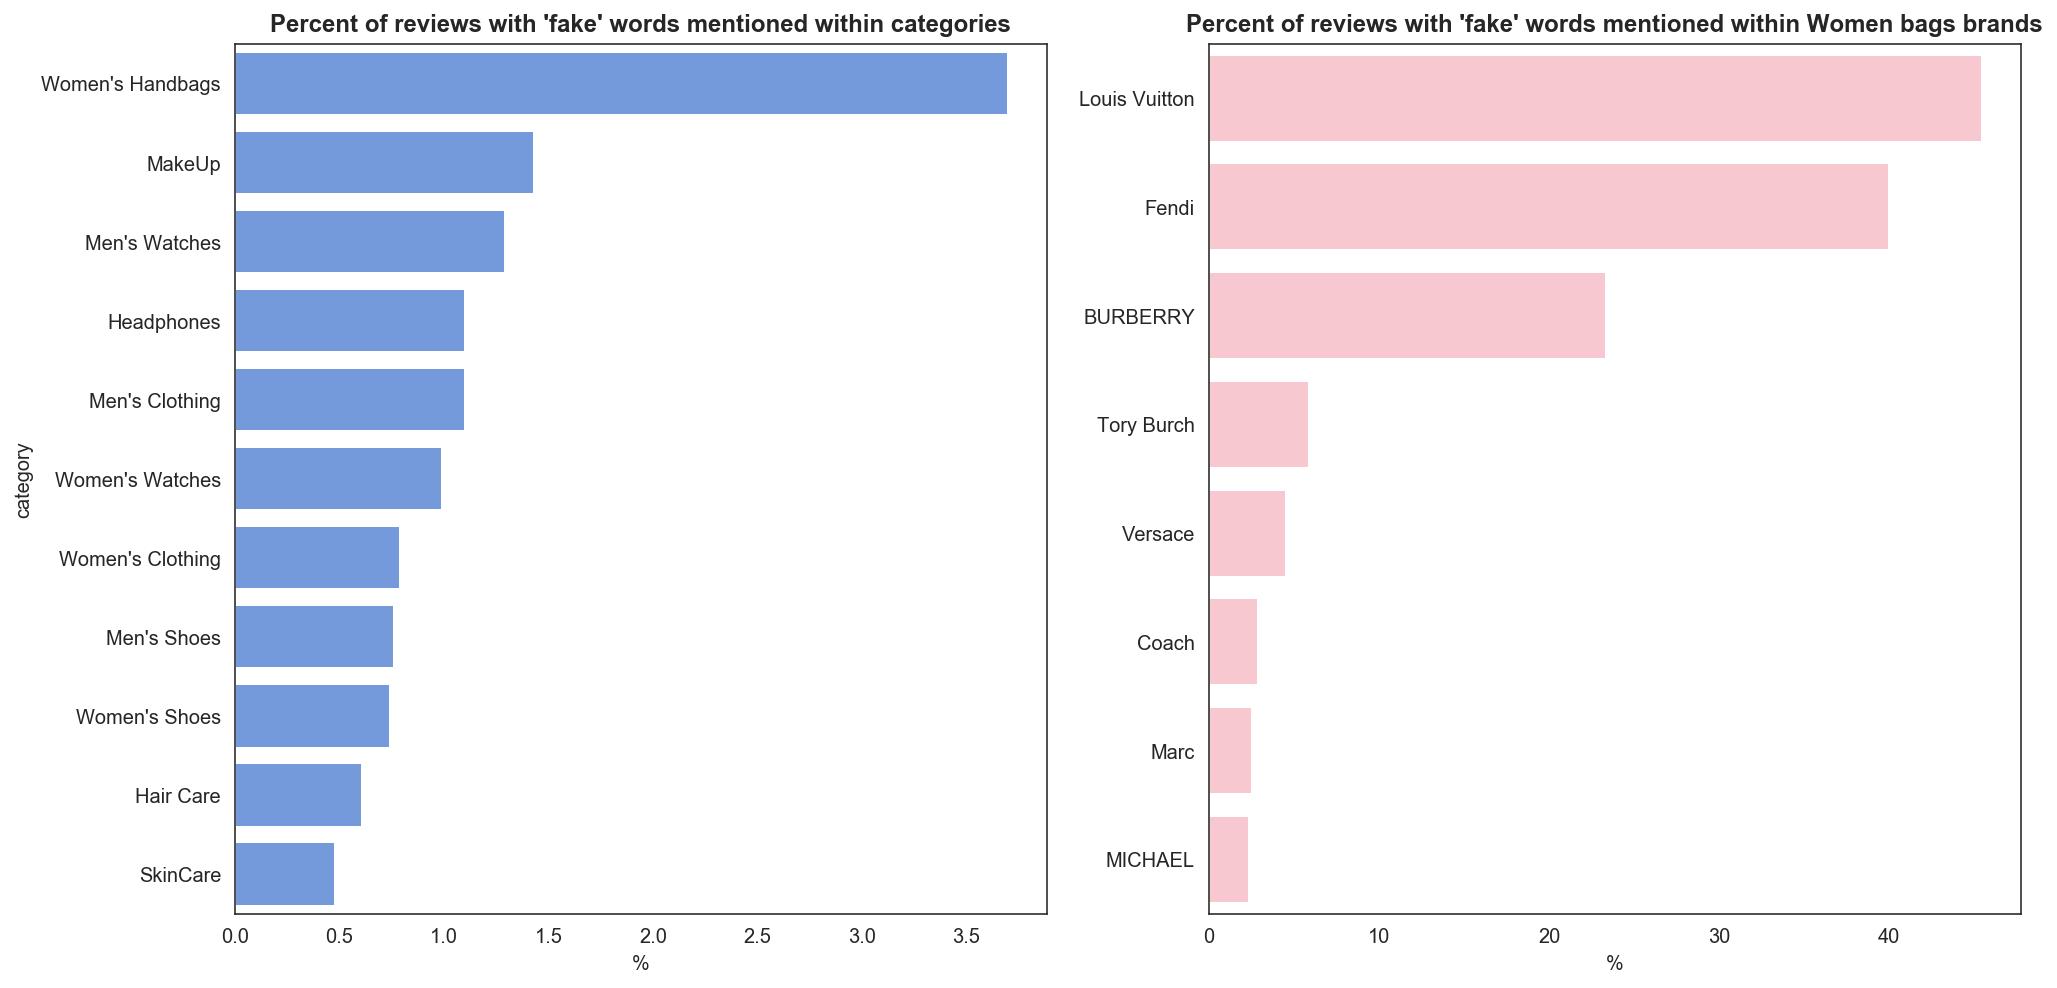

In [649]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
sns.barplot(x=flag_fruad_cat['percentage'], y = flag_fruad_cat['category'], color="cornflowerblue")
plt.xlabel("%")
plt.title("Percent of reviews with 'fake' words mentioned within categories", fontweight='bold', fontsize=12);

plt.subplot(1,2,2)
sns.barplot(x=flag_women_bag_cat[flag_women_bag_cat['percentage']>1]['percentage'], 
            y = flag_women_bag_cat[flag_women_bag_cat['percentage']>1]['brand'], color="pink")
plt.title("Percent of reviews with 'fake' words mentioned within Women bags brands", fontweight='bold', fontsize=12)
plt.xlabel("%")
plt.ylabel("");

The majority of reviews that have mentions of words such as 'fraud', 'fake', or 'counterfeit' in the "Women's Handbags" category (3.7%) largly came from luxury segment brands (Louis Vuitton - 45%, Fendi - 40%, BURBERRY - 23.33%). 

To get a better understanding of which brands are more exposed to grey market I will use NLP to tag more reviews that describe it.

For that, I will clean/preprocess reviews' text and then use topic modeling to find a topic that describes counterfeit products.

# NLP/topic modeling/text pre-processing steps

In [49]:
df.shape

(358798, 29)

Since our dataset includes almost 360k reviews, running any tests on these amount of data would be expensive. <br>For that reason, I will explore the bags category and then apply any findings/results from that on a bigger category.

In [52]:
# To start I will separate/filter DataFrame for "Women's Handbags"

df_bags = df[df['category'] == "Women's Handbags"].copy().reset_index().drop(columns=['index'])

Before any text manipulations - the text needs to be cleaned/preprocessed.

In [467]:
def text_cleaning(text):
    
    """ Text preprocessing/cleaning """
    
    import re # regex library
    import string
    
    text = text.lower() # Make text lowercase
    text = re.sub('\[.*?\]', '', text) # remove text in square brackets if any
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    text = re.sub('\d*', '', text) # remove numbers containing numbers
    text = re.sub('[‘’“”…]', '', text) # some additional punctuation and non-sensical text
    text = re.sub('\n', '', text) # line separaters if any
    
    return text

In [55]:
df_bags['review_clean'] = df_bags['body'].apply(text_cleaning)

In [57]:
df_bags.head(3)

,asin,review_post_id,body,review_text,helpful_count,num_images,rating,date_posted,is_verified_purchase,is_vine_voice,...,is_fresh,has_sns,offer_fulfiller,offer_merchant,lowest_price_new_condition,brand,num_reviews,num_images_pdp,Flag_fraud_words,review_clean
0,B06WRSNP4M,RZZ4N2EBFGLC8,Kids got it for mothers day. She seems to lik...,kids got mothers day. she seems like it.,2,0,5,2017-05-28,True,False,...,False,False,shophydra,shophydra,79.98,MICHAEL,84,5,False,kids got it for mothers day she seems to like it
1,B01K87JER4,RZPAUDLYFYIR5,I love my bag. its not to heavy and it has man...,i love bag. heavy many compartments. i never p...,0,0,5,2018-02-07,True,False,...,False,False,shophydra,shophydra,185.31,MICHAEL,1,6,False,i love my bag its not to heavy and it has many...
2,B01K87JER4,RZ9E2WM0PDZCL,Got a defective piece. The bad handle has thre...,got defective piece. the bad handle threads it...,0,2,1,2018-04-08,True,False,...,False,False,shophydra,shophydra,185.31,MICHAEL,1,6,False,got a defective piece the bad handle has threa...


### First model: NMF

After cleaning the reviews I will use a NLP technique called topic modeling to see what people are talking about most and see if a topic around 'fake' and 'fraud' would form.

For topic modeling I will use TfidfVectorizer and Non-Negative Matrix Factorization (NMF), which perform better on short texts such as tweets or in our case reviews.

In [58]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

In [59]:
# function for displaying topics - will be used further in the topic modeling analysis

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [60]:
reviews = df_bags['review_clean'].to_list()

In [61]:
# set stop_words as 'english' - for excluding any common english words from forming topics
# set ngram_range=(1, 2) - to make any words combinations

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), analyzer='word', token_pattern=r'\b[^\d\W]+\b')
doc_word = tfidf.fit_transform(reviews)
doc_word.shape

(1676, 13136)

In [62]:
pd.DataFrame(doc_word.toarray(), index=reviews, columns=tfidf.get_feature_names()).head(1)

,aaaaamazing,aaaaamazing great,able,able better,able easily,able files,able fit,able little,able phone,able relate,...,zippers great,zippers smoothly,zippers strong,zippers sturdydependable,zippers work,zipping,zipping easily,zips,zips ive,zips zipper
kids got it for mothers day she seems to like it,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# set 5 topics to begin with

nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_word)

In [64]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = (["component_1","component_2", "component_3",
                      "component_4","component_5"]),
             columns = tfidf.get_feature_names())
topic_word

,aaaaamazing,aaaaamazing great,able,able better,able easily,able files,able fit,able little,able phone,able relate,...,zippers great,zippers smoothly,zippers strong,zippers sturdydependable,zippers work,zipping,zipping easily,zips,zips ive,zips zipper
component_1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000
component_2,0.002,0.002,0.018,0.004,0.001,0.003,0.001,0.003,0.002,0.002,...,0.002,0.002,0.001,0.005,0.009,0.0,0.0,0.003,0.002,0.000
component_3,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.001,0.000,0.000,0.000,0.003,0.0,0.0,0.002,0.003,0.000
component_4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.001,0.001,0.000,0.004,0.0,0.0,0.000,0.000,0.000
component_5,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.001,0.000,0.001


In [67]:
doc_topic_nmf = pd.DataFrame(doc_topic.round(5),
                             index = df_bags['body'],
                             columns = (["component_1","component_2", "component_3",
                                          "component_4","component_5"]))
doc_topic_nmf.head(3)

,component_1,component_2,component_3,component_4,component_5
body,,,,,
Kids got it for mothers day. She seems to like it.,0.00017,0.00889,0.00291,0.00381,0.00738
"I love my bag. its not to heavy and it has many compartments. I never put it on the floor, I hang it in my desk and on my closet, the handles lasted so far. I've been using it for about 3 months",0.02315,0.01651,0.00072,0.00175,0.00000
Got a defective piece. The bad handle has threads all over it. May not be a real MK product.,0.00000,0.01128,0.00200,0.00000,0.00579


In [68]:
display_topics(nmf_model, tfidf.get_feature_names(), 20)


Topic  0
love, love love, love bag, love purse, bag, absolutely love, absolutely, purse, love color, love wallet, love perfect, wallet, color, just, love holds, small love, holds, exactly, love wristlet, beautiful love

Topic  1
great, perfect, beautiful, bag, size, purse, quality, perfect size, love bag, product, great quality, color, great product, price, great bag, great price, just, expected, like, small

Topic  2
good, good quality, quality, good product, look good, price, look, good size, product, small good, good price, good bag, small, quality good, service, bag good, material good, service good, good like, like

Topic  3
nice, nice bag, nice purse, bag, like, nice quality, purse, small, nice small, really nice, quality, love nice, smaller, really, leather, big, thank, nice like, nice size, expected

Topic  4
loves, wife, wife loves, loved, gift, daughter, daughter loves, bought, wife loved, purse, loves purse, bought gift, loves gift, mom, gift daughter, got, gift loves, mom 

<br><br><br>
After the first attempt these topics did not make sense, moreover, none of them mentioned 'fraud' or 'fake'.<br>
To create a better/more coherent list topics I will expend a stop words list and maybe further clean reviews.

I can continue to iterate and clean the reviews, however, I decided to use another NLP technique for topic modeling called **CorEx**

### CorEx on a smaller data (bags category)

CorEx is a semi-unsupervised learning algorithm that can pick up smaller topics by using domain knowledge and assigning anchors to certain words 

In [71]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [73]:
from sklearn.feature_extraction.text import CountVectorizer
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
import warnings

In [74]:
# run first CorEx model without anchors

vectorizer = CountVectorizer(max_features=20000,
                             stop_words='english', token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True)

doc_word = vectorizer.fit_transform(reviews)
words = list(np.asarray(vectorizer.get_feature_names()))

In [75]:
topic_model = ct.Corex(n_hidden=6, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=df_bags.body)

In [76]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: bit,make,large,black,look,people,klein,outer,calvin,really
1: like,stars,feels,plastic,didnt,months,want,shoe,thing,cheap
2: michael,kors,im,coach,kate,spade,bag,bags,purchase,real
3: phone,size,fits,fit,iphone,perfect,keys,pocket,need,carry
4: pockets,strap,year,use,body,zipper,crossbody,cross,space,plenty
5: loves,wife,gift,bought,love,loved,christmas,daughter,birthday,said


#### CorEx with TDIF

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.corpus import stopwords

Next, I will run the model using anchor words such as ['fake', 'cheap', 'counterfeit', 'knock'] as well as create a stop_words list that includes any mentions of brand, category, or words like 'love' and 'like'.<br><br>
Also I decided to add anchor words that describe quality, since most of the bags in this dataset are in the luxary segment and 'poor quality' might be an indicator for the product being fake/counterfeit.
<br>

##### Disclaimer: I won't use 'poor quality' for other categories in my analysis, since 'poor quality' is likely exclusively good as an indicator to high priced goods such as luxury segment bags, because people expect a greate quality LV bag. However, for the shoes category this could be misleading.

In [115]:
stop_words = stopwords.words('english')

In [152]:
new_stop_words = ['bag', 'bags', 'm', 's', 't', 'love', 'like', 'loves', 'likes', 'loved', 'purse', 'mk']

In [117]:
brands = df_bags['brand'].unique()

In [118]:
brands = [brand.lower().strip() for brand in brands]

In [119]:
brands_ = []
for br in brands:
    a = br.split(' ')
    brands_+=a

In [120]:
brands_ = list(set(brands_))

In [153]:
stop_words.extend(new_stop_words)

In [122]:
stop_words.extend(brands_)

In [123]:
tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2), analyzer='word', token_pattern=r'\b[^\d\W]+\b')

In [124]:
doc_word = tfidf.fit_transform(reviews)
doc_word.shape

(1676, 13746)

In [125]:
words = list(np.asarray(tfidf.get_feature_names()))

In [126]:
topic_model = ct.Corex(n_hidden=4, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df_bags.body, 
                anchors=[['fake', 'counterfeit', 'knock', 'fraud'], ['cheap', 'poor']], anchor_strength=20)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: fake,fraud,knock,counterfeit,fake product,looks fake,real one,shown,nice,fake sure
1: cheap,poor,poor quality,twice,seller,months,mk,id,mk purses,skeptical
2: holds,made,beautifully,inside pockets,white,useful,holds everything,beautifully made,shoes,inside
3: scent,shape,strap broke,big nice,lots space,nice item,person,size appearance,appearance,quicker


In [127]:
predictions = pd.DataFrame(topic_model.p_y_given_x, columns=[i for i in range(4)],
                          index=df_bags.body)

In [130]:
predictions.head(15)

,0,1,2,3
body,,,,
Kids got it for mothers day. She seems to like it.,0.001053,0.008331,0.999999,0.035669
"I love my bag. its not to heavy and it has many compartments. I never put it on the floor, I hang it in my desk and on my closet, the handles lasted so far. I've been using it for about 3 months",0.001163,0.005486,0.115066,0.999999
Got a defective piece. The bad handle has threads all over it. May not be a real MK product.,0.001811,0.999999,0.041945,0.032372
"I purchased this to be a Christmas gift for my mother. I actually loved the wristlet and I think she would have too. So, it's unfortunate that I needed to return it due to a green discoloration along the seams of the bag. This was my very first Michael Kors purchase ever and I have to say that I'm disappointed and leery about buying this brand in the future. :(",0.000502,0.000117,0.011816,0.999999
"Bought for girlfriend. She loves it, plenty of pocket space.",0.000171,0.006348,0.999999,0.041779
My wife loves this purse! Very fast delivery!,0.000752,0.001773,0.088054,0.012860
It arrived and i love it! Its the real deal,0.001053,0.003065,0.014897,0.016488
nice item for present. iPhone 7plus fits well..,0.000868,0.006348,0.113453,0.999999
Everything came as advertised. I’m sure the wife will love it!,0.001258,0.008509,0.999999,0.041823


The resulting topics seemed better for tagging reviews that describeed faulty products. However, its not good enough.

Reviews that are 4-5 starts seems to skew the topics that are being formed - bringing more noise in identifying 'fake'/'fraud' reviews.
<br><br>
To avoid that I will filter the data for 3 star and below reviews.

##### Topic modeling on 3 star and below reviews to ignore 'noise' from 4,5 star reviews

From my experience working with text data - better results are achieved when using Tokenization and POS-tagging technique (part of speach).

In [131]:
from nltk import word_tokenize, pos_tag

In [468]:
def nouns_adj_verbs(text):
    """ Tokenizing text and leaving only Verbs, Nouns, and Adjetives """
    
    is_noun_adj_verb = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ' or pos[:2] == 'VB'
    tokenized = word_tokenize(text)
    nouns_adj_verb = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj_verb(pos)] 
    return ' '.join(nouns_adj_verb)

In [134]:
df_bags['reviews_nltk'] = df_bags['review_clean'].apply(nouns_adj_verbs)

In [136]:
# Sort the data for 3 star reviews and below

df_bags_below = df_bags[df_bags['rating'] < 4].copy()

In [55]:
tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2), analyzer='word', token_pattern=r'\b[^\d\W]+\b')

In [137]:
reviews = df_bags_below.reviews_nltk.to_list()

In [138]:
doc_word = tfidf.fit_transform(reviews)
doc_word.shape

(303, 3681)

In [139]:
words = list(np.asarray(tfidf.get_feature_names()))

In [140]:
topic_model = ct.Corex(n_hidden=4, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df_bags_below.body, 
                anchors=[['fake', 'counterfeit', 'knock', 'fraud'],['cheap', 'poor']], anchor_strength=20)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: fake,fraud,knock,fake product,looks fake,believe,fake sure,small,fake order,believe fake
1: cheap,poor,poor quality,purple,looks cheap,cheap price,stylish,department,cheap plastic,overall
2: shoulder,expected,smaller expected,wish,tried,times,dont recommend,lot,accurate,dec
3: copy,serial,doesnt,serial number,scam,know,part,sample,pull missing,number


In [141]:
predictions = pd.DataFrame(topic_model.p_y_given_x, columns=[i for i in range(4)],
                          index=df_bags_below.body)

In [142]:
predictions

,0,1,2,3
body,,,,
Got a defective piece. The bad handle has threads all over it. May not be a real MK product.,0.000001,0.000001,0.000064,0.999999
"I purchased this to be a Christmas gift for my mother. I actually loved the wristlet and I think she would have too. So, it's unfortunate that I needed to return it due to a green discoloration along the seams of the bag. This was my very first Michael Kors purchase ever and I have to say that I'm disappointed and leery about buying this brand in the future. :(",0.000001,0.000117,0.999989,0.999999
Returned. Zipper pull was missing and I couldn't understand why.,0.000004,0.003688,0.074546,0.999999
Long zipper part was not on wallet,0.000002,0.003704,0.050430,0.999999
The clutch is pretty but it is too small.,0.000005,0.002728,0.088829,0.019887
...,...,...,...,...
"These bags are not authentic. I have 5 coach bags. The engraving and name plate on a real COACH bag will only read COACH, NOTHING ELSE. These are fake.....BEWARE",0.000002,0.001191,0.022465,0.999999
I gave as a gift and I did not realize it was so small until it was unwrapped. But other than that the purse is really cute.,0.000002,0.003705,0.109893,0.999999
"Very disappointed that's there was a 15% restocking charge! I returned this Coach bag because it seemed like a seconds bag. The leather on the front of the bag was not stitched properly & looked bumpy, not up to Coach standards. I have purchased many Coach bags but this one was just mediocre quality. I won't shop with this company again.",0.000001,0.000061,0.999999,0.006854


**I did a couple other iterations with topics by assigning different anchors and playing around with new anchor words (I deleted these iterations from this jupyter notebook since it seems redundent).**<br><br>
As a result, I added a few more anchor words to pick up more reviews.

### CorEx second iteration

#### Re-do topic modeling / adding 'original','real', 'authentic' to anchor words. Also, adding a few more words to drive attention from main topics ('fake', 'not real')

In [154]:
tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2), analyzer='word', token_pattern=r'\b[^\d\W]+\b')

In [144]:
reviews = df_bags_below.reviews_nltk.to_list()

In [145]:
doc_word = tfidf.fit_transform(reviews)
doc_word.shape

(303, 3681)

In [146]:
words = list(np.asarray(tfidf.get_feature_names()))

In [158]:
topic_model = ct.Corex(n_hidden=4, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df_bags_below.body, 
                anchors=[['fake', 'counterfeit', 'knock', 'fraud', 'real','original', 'authentic'], # 'imitation', 'scam'
                         ['cheap', 'poor', 'cheep'],
                         ['pretty']], anchor_strength=20)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics(n_words=12)
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: fake,authentic,fraud,real,original,knock,small,fake product,looks fake,feels,believe,item
1: cheap,poor,cheep,poor quality,purple,chinese,cheep chinese,looks cheap,cheap price,department,cheap plastic,overall
2: pretty,serial,number,serial number,hate,inside,refund,side,toes,next,comment,returned next
3: pull missing,clutch,clutch small,bottle,part,likable,wasnt likable,end,anticipated,zipper part,part wallet,change


In [159]:
predictions = pd.DataFrame(topic_model.p_y_given_x, columns=[i for i in range(4)],
                          index=df_bags_below.body)

In [160]:
predictions

,0,1,2,3
body,,,,
Got a defective piece. The bad handle has threads all over it. May not be a real MK product.,0.999999,0.000876,0.012372,0.023010
"I purchased this to be a Christmas gift for my mother. I actually loved the wristlet and I think she would have too. So, it's unfortunate that I needed to return it due to a green discoloration along the seams of the bag. This was my very first Michael Kors purchase ever and I have to say that I'm disappointed and leery about buying this brand in the future. :(",0.000001,0.000050,0.004998,0.999998
Returned. Zipper pull was missing and I couldn't understand why.,0.000095,0.001651,0.028641,0.999999
Long zipper part was not on wallet,0.000002,0.001651,0.028373,0.999999
The clutch is pretty but it is too small.,0.000011,0.001651,0.027957,0.999999
...,...,...,...,...
"These bags are not authentic. I have 5 coach bags. The engraving and name plate on a real COACH bag will only read COACH, NOTHING ELSE. These are fake.....BEWARE",0.999999,0.001651,0.999999,0.056987
I gave as a gift and I did not realize it was so small until it was unwrapped. But other than that the purse is really cute.,0.000033,0.001764,0.999999,0.056998
"Very disappointed that's there was a 15% restocking charge! I returned this Coach bag because it seemed like a seconds bag. The leather on the front of the bag was not stitched properly & looked bumpy, not up to Coach standards. I have purchased many Coach bags but this one was just mediocre quality. I won't shop with this company again.",0.000001,0.000371,0.000820,0.000315


Assigning each review to each topic by majority vote.

In [161]:
predictions['majority'] = np.argsort(-predictions, axis=1)[0]

In [166]:
# Topics distribution

round(predictions['majority'].value_counts(normalize=True)*100,)

3    42.0
0    25.0
2    21.0
1    12.0
Name: majority, dtype: float64

In [167]:
predictions = predictions.reset_index()

#### Visualizing topics with t-distributed Stochastic Neighbor Embedding

In [168]:
from sklearn.manifold import TSNE

In [191]:
##t-SNE is a tool to visualize high-dimensional data.

tsne = TSNE(n_components=2, verbose=0, metric='cosine', perplexity=70, n_iter=1000)

In [192]:
doc_topic = predictions.iloc[:,1:5]

In [193]:
tsne_results = tsne.fit_transform(doc_topic)

In [194]:
predictions['tsne-2d-one'] = tsne_results[:,0]
predictions['tsne-2d-two'] = tsne_results[:,1]

In [173]:
predictions.replace({'majority': {0: 'fraud', 1: 'poor/quality', 2: 'other_1', 3: 'other_2'}}, inplace=True)

In [174]:
predictions['majority'].unique()

array(['fraud', 'other_2', 'other_1', 'poor/quality'], dtype=object)

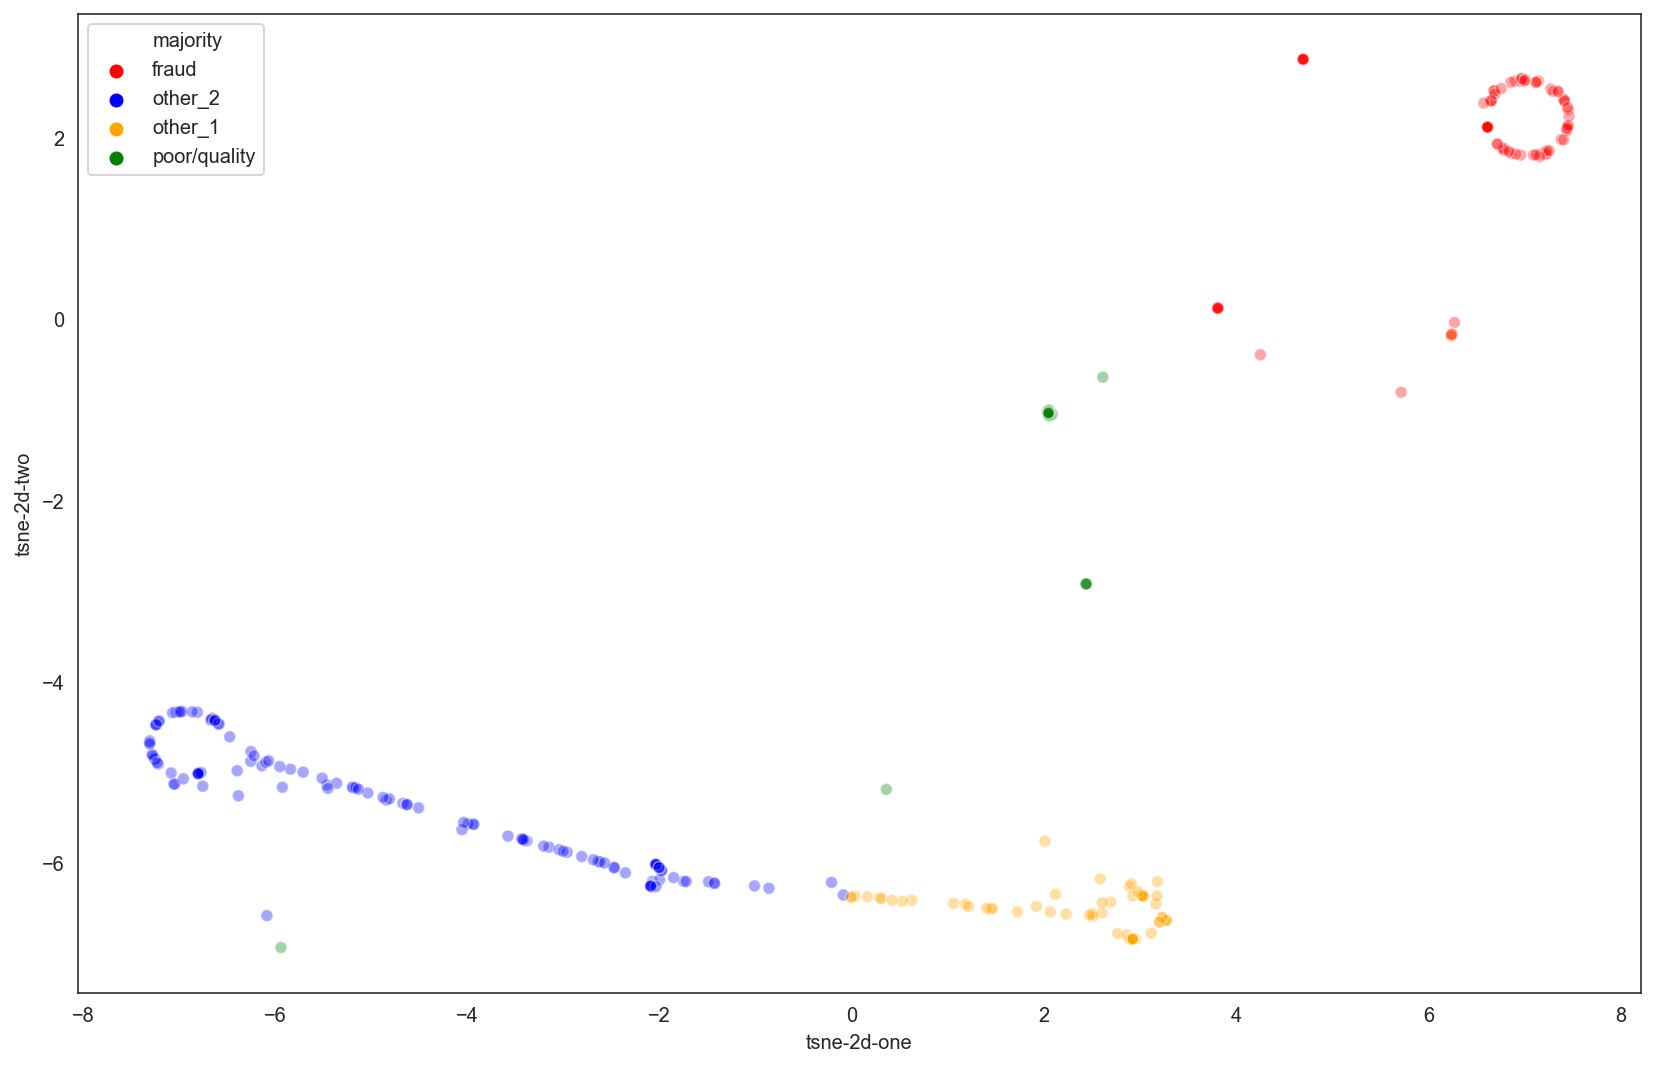

In [196]:
plt.figure(figsize=(14,9))

sns.set_style('white')
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="majority",
    palette = ['red', 'blue', 'orange', 'green'], 
    data=predictions,
    legend="full",
    alpha=0.35
);

Topics are pretty coherent, especially the one that describes fraud/fake. "Poor quality" formed quite nicely as well. How other topics distributed/formed doesn't matter, since I want to distinguish only the 'fake' one.

Now, merge predicted topics with the main DataFrame for bags.

In [202]:
df_bag_all = pd.merge(df_bags, predictions, on='body', how='left')

In [204]:
df_bag_all.drop(columns=[0,1,2,3,'tsne-2d-one','tsne-2d-two','review_clean'], inplace=True)

#### Now after I have formed the steps for modeling on a smaller set, I will apply it to a larger category, such as shoes 

# Larger category modeling (Shoes)

##### Perform analysis on a bigger category (Women's Shoes and Men's Shoes)

In [462]:
round(df['category'].value_counts(normalize=True)*100)

SkinCare            27.0
Men's Shoes         25.0
Women's Shoes       18.0
Men's Clothing      10.0
MakeUp               9.0
Women's Clothing     5.0
Hair Care            3.0
Headphones           2.0
Men's Watches        1.0
Women's Handbags     0.0
Women's Watches      0.0
Name: category, dtype: float64

In [463]:
df_shoes = df[df['category'].isin(["Women's Shoes", "Men's Shoes"])].reset_index().drop(columns=['index'])

In [464]:
df_shoes.shape

(153065, 29)

**Filter DataFrame for 3 stars and below**

In [465]:
df_shoes_below = df_shoes[df_shoes['rating'] < 4].copy()

In [466]:
df_shoes_below.shape

(28307, 29)

In [180]:
#df_shoes.dropna(subset=['body'], inplace=True)

#### CorEx on shoe category

In [469]:
df_shoes_below['reviews_clean'] = df_shoes_below['body'].apply(text_cleaning)

In [470]:
df_shoes_below['nltk_reviews'] = df_shoes_below['reviews_clean'].apply(nouns_adj_verbs)

In [471]:
from sklearn.feature_extraction import text
from nltk.corpus import stopwords

In [472]:
# find all shoe brands to add them to the stopwords list

brands = df_shoes['brand'].unique()

In [473]:
brands = [brand.lower().strip() for brand in brands]

In [474]:
brands_ = []
for br in brands:
    a = br.split(' ')
    brands_+=a

In [475]:
brands_ = list(set(brands_))

In [476]:
more_stop_words = ['shoe', 'shoes', 'sandal', 'sandals', 'new', 'tom', 'toms', 'ascics', 'asics',
                   'birkenstock', 'birkenstocks', 'birks', 'gt', 'nimbus', 'e', 'ee', 
                   'balance', 'kayano', 'sneakers', 'like', 'made', 'xl', 'small',
                   'kayanos', 'cumulus','velcro', 'asic', 'nb', 'cork', 'buckle', 'sneaker']

In [477]:
stop_words = stopwords.words('english')

In [478]:
stop_words.extend(more_stop_words)

In [479]:
stop_words.extend(brands_)

In [615]:
tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2), analyzer='word', token_pattern=r'\b[^\d\W]+\b')

In [616]:
reviews = df_shoes_below.nltk_reviews.to_list()

**First run**

In [617]:
doc_word = tfidf.fit_transform(reviews)
doc_word.shape

(28307, 206963)

In [485]:
words = list(np.asarray(tfidf.get_feature_names()))

In [231]:
topic_model = ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df_shoes_below.body, 
                anchors=[['fake', 'counterfeit', 'knock', 'fraud', 'legit', 'scam'], # 'imitation', 'legit'
                         ['original', 'real', 'authentic', 'logo']], anchor_strength=20) # 'logo'

# Print all topics from the CorEx topic model
topics = topic_model.get_topics(n_words=12)
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: fake,knock,scam,counterfeit,legit,fraud,knock offs,offs,narrow,size,fake buy,fake fake
1: real,original,authentic,logo,real leather,sure real,original box,sure authentic,real thing,real deal,real ones,wide
2: gel flux,flux,think seconds,dyed,gray picture,quiero,runs guess,stiff get,purchase used,shuffle,return needed,wear cold
3: smallhad return,smallhad,blew,started ripping,security,security tag,husband hates,liked least,narow,bad good,side blew,siz
4: miles,running,years,ive,heel,many,pair,first,im,pain,reviews,time
5: sporting,sporting goods,navy,dirty box,navy blue,thrm,color grey,goods store,blue,left toe,memory tech,top strap


In [232]:
predictions = pd.DataFrame(topic_model.p_y_given_x, columns=[i for i in range(6)],
                          index=df_shoes_below.body)

In [233]:
predictions

,0,1,2,3,4,5
body,,,,,,
Package came with the end missing from the box. Since it’s a gift I will have to update for actual fit.,0.005614,0.005729,0.015032,0.003606,0.055096,0.022648
They are totally fake 😡. They felt weird and I finally noticed that the “Made in Germany” is below the logo and it should be above. They also smell like glue not leather. Infuriating that this can happen!,0.999999,0.999999,0.015064,0.975377,0.027182,0.017075
I've been a Birkenstock wearer for over 35 years. I do wear a 10 in women's size but the ones I ordered wear to big. I need to size down.,0.001583,0.000319,0.014858,0.976725,0.024522,0.015268
"The shoes were stiff, sharp edges on the foot bed, too small, nothing seemed right I sent them back. I have since then bought three pair from Birkenstock and they are just as all the others I had before.",0.999925,0.003876,0.010255,0.988601,0.026649,0.018425
These shoes have been worn for 2 months and one of the rubber soles completely detached. I have worn Birkenstocks for years and this never happens. Maybe a knock off. Don't buy,0.999999,0.006851,0.014538,0.978207,0.027962,0.017624
...,...,...,...,...,...,...
To tight in the toes,0.002102,0.001007,0.014877,0.977488,0.021305,0.017093
"Shoes are too tight. I have another pair of adidas that fit me great, so disappointed these don’t, and can’t return them.Color is a little different than what I saw. Tan with a slight mauve tone, which I did not pick up on in photo.",0.999999,0.005191,0.017719,0.976969,0.025438,0.006712
"Awesome shoes but I needed a wide and these were very narrow, other that that I loved them.",0.001386,0.000598,0.008713,0.976394,0.026421,0.017119


In [234]:
predictions['majority'] = np.argsort(-predictions, axis=1)[0]

In [235]:
predictions['majority'].value_counts()

3    16129
4     3790
0     2613
1     2458
5     1828
2     1489
Name: majority, dtype: int64

In [236]:
predictions = predictions.reset_index()

### CorEx

**Second run** _(adding new 'anchor' for the 3rd topic to drive 'attention' from main topics ('fake','not real')_

In [486]:
topic_model = ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df_shoes_below.body, 
                anchors=[['fake', 'counterfeit', 'knock', 'fraud', 'legit', 'scam'], # 'imitation', 'legit'
                         ['original', 'real', 'authentic', 'logo'], ['size']], anchor_strength=20) # 'logo'

# Print all topics from the CorEx topic model
topics = topic_model.get_topics(n_words=12)
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: fake,knock,scam,counterfeit,legit,fraud,knock offs,offs,narrow,fake buy,fake fake,fake dont
1: real,original,authentic,logo,real leather,sure real,original box,sure authentic,real thing,wide,real deal,real ones
2: size,half size,ordered size,half,size larger,larger,ordered,size bigger,bigger,size smaller,wear size,true size
3: blew,smallhad return,smallhad,side blew,started ripping,gel flux,flux,husband hates,thight,little thight,adjustable strap,comfortable cute
4: miles,ive,running,heel,pair,years,find,im,pain,mile,first,something
5: black,gray,gray black,blue,dirty box,pinky toe,thrm,color grey,purple black,day gift,pinky,back ripped


In [516]:
predictions = pd.DataFrame(topic_model.p_y_given_x, columns=[i for i in range(6)],
                          index=df_shoes_below.body)

In [517]:
predictions

,0,1,2,3,4,5
body,,,,,,
Package came with the end missing from the box. Since it’s a gift I will have to update for actual fit.,0.000615,0.000137,0.002522,0.003393,0.003095,0.994983
They are totally fake 😡. They felt weird and I finally noticed that the “Made in Germany” is below the logo and it should be above. They also smell like glue not leather. Infuriating that this can happen!,0.999999,0.999999,0.007230,0.965689,0.021369,0.975989
I've been a Birkenstock wearer for over 35 years. I do wear a 10 in women's size but the ones I ordered wear to big. I need to size down.,0.005451,0.004713,0.999999,0.971364,0.025355,0.972728
"The shoes were stiff, sharp edges on the foot bed, too small, nothing seemed right I sent them back. I have since then bought three pair from Birkenstock and they are just as all the others I had before.",0.999987,0.003904,0.007090,0.972580,0.021360,0.985340
These shoes have been worn for 2 months and one of the rubber soles completely detached. I have worn Birkenstocks for years and this never happens. Maybe a knock off. Don't buy,0.999999,0.004452,0.000689,0.972564,0.020659,0.976181
...,...,...,...,...,...,...
To tight in the toes,0.001747,0.000876,0.009078,0.969384,0.016153,0.975856
"Shoes are too tight. I have another pair of adidas that fit me great, so disappointed these don’t, and can’t return them.Color is a little different than what I saw. Tan with a slight mauve tone, which I did not pick up on in photo.",0.999999,0.006499,0.004482,0.983735,0.012059,0.978045
"Awesome shoes but I needed a wide and these were very narrow, other that that I loved them.",0.001071,0.000457,0.012706,0.981354,0.002671,0.990308


In [518]:
predictions['majority'] = np.argsort(-predictions, axis=1)[0]

In [519]:
predictions['majority'].value_counts()

5    10279
2     5564
3     5351
0     2599
1     2455
4     2059
Name: majority, dtype: int64

In [520]:
predictions = predictions.reset_index()

#### Visualizing topics with t-distributed Stochastic Neighbor Embedding

In [525]:
from sklearn.manifold import TSNE

In [526]:
##t-SNE is a tool to visualize high-dimensional data.

tsne = TSNE(n_components=2, verbose=0, metric='cosine', perplexity=70, n_iter=2000)

In [527]:
predictions.shape

(28307, 8)

In [528]:
doc_topic = predictions.iloc[:,1:7]

In [529]:
tsne_results = tsne.fit_transform(doc_topic)

In [530]:
predictions['tsne-2d-one'] = tsne_results[:,0]
predictions['tsne-2d-two'] = tsne_results[:,1]

In [514]:
# predictions.replace({'majority': {0: '0 - fraud', 1: '1 - not real/authentic', 2: '2 - other (size)',
#                                   3: '3 - other_2', 4: '4 - other_3', 5: '5 - other_4'}}, inplace=True)

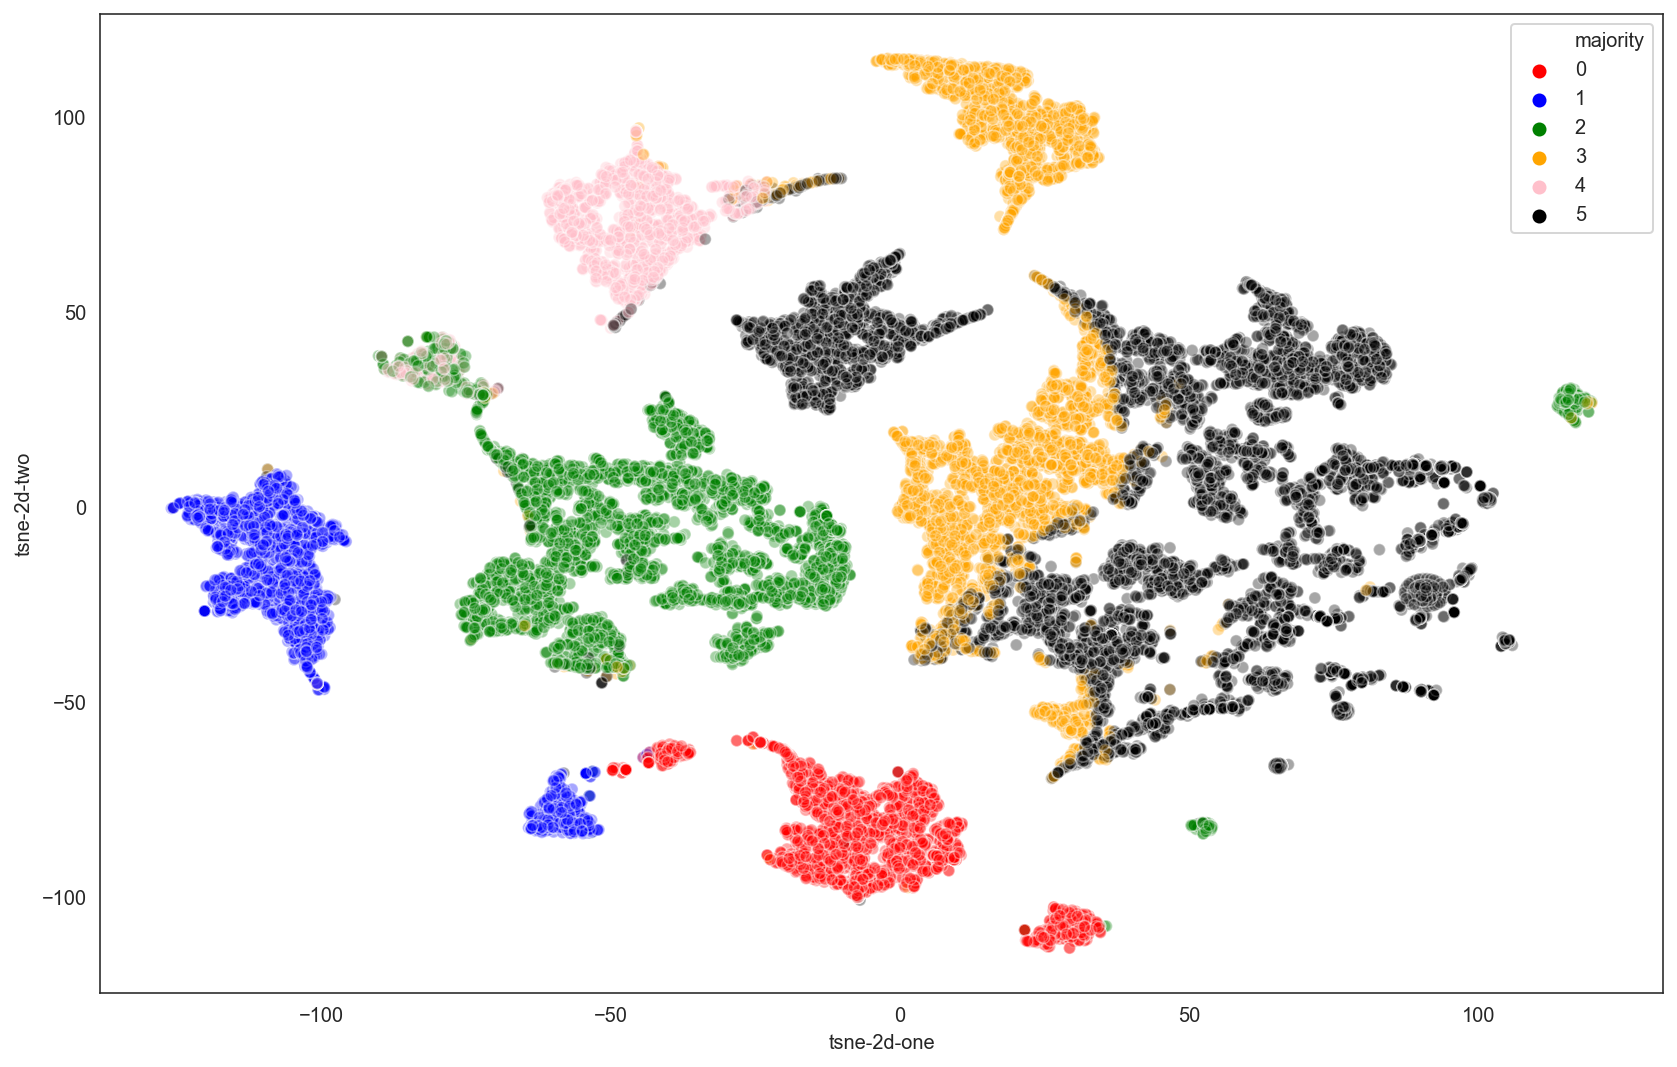

In [531]:
plt.figure(figsize=(14,9))

sns.set_style('white')
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="majority",
    palette = ['red', 'blue', 'green', 'orange', 'pink', 'black'], 
    data=predictions,
    legend="full",
    alpha=0.35
);

Topics for **fraud (0)** and **not real/original/logo (1)** are formed well. How other topics formed - doesn't matter

#### Join topics with the main DataFrame

In [532]:
df_shoes_all = pd.merge(df_shoes, predictions, how='left', on='body')

In [533]:
df_shoes_all.drop(columns=[0,1,2,3,4,5,'tsne-2d-one', 'tsne-2d-two'], inplace=True)

In [534]:
# replace topics 0,1 in majority to 1 and the rest topics - 0

df_shoes_all['majority'].replace({0:1,2:0,3:0,4:0,5:0}, inplace=True)

In [536]:
# fill null values for 4 and 5 star reviews

df_shoes_all['majority'].fillna(0, inplace=True)

In [537]:
df_shoes_all.columns

Index(['asin', 'review_post_id', 'body', 'review_text', 'helpful_count',
       'num_images', 'rating', 'date_posted', 'is_verified_purchase',
       'is_vine_voice', 'num_comments', 'has_video', 'category', 'list_price',
       'price_low', 'price_high', 'is_add_on', 'is_prime', 'is_prime_pantry',
       'is_prime_exclusive', 'is_fresh', 'has_sns', 'offer_fulfiller',
       'offer_merchant', 'lowest_price_new_condition', 'brand', 'num_reviews',
       'num_images_pdp', 'Flag_fraud_words', 'majority'],
      dtype='object')

In [538]:
df_shoes_all['helpful_count_weight'] = df_shoes_all['helpful_count']

In [539]:
# to integrate helpful counts to the algorithm I'm changing 0 counts to 1 for further multiplication
# in case my model missclassified some helpful 'fraud' reviews

df_shoes_all['helpful_count_weight'].replace({0:1}, inplace=True)

In [540]:
df_shoes_all['weight_fake_rev'] = df_shoes_all['majority']*df_shoes_all['helpful_count_weight']

Reviews that mentions fake within brands.

In [541]:
df_shoes_all['num_reviews_brand'] = df_shoes_all.groupby('brand').review_post_id.transform('count')

In [546]:
df_shoes_all.columns

Index(['asin', 'review_post_id', 'body', 'review_text', 'helpful_count',
       'num_images', 'rating', 'date_posted', 'is_verified_purchase',
       'is_vine_voice', 'num_comments', 'has_video', 'category', 'list_price',
       'price_low', 'price_high', 'is_add_on', 'is_prime', 'is_prime_pantry',
       'is_prime_exclusive', 'is_fresh', 'has_sns', 'offer_fulfiller',
       'offer_merchant', 'lowest_price_new_condition', 'brand', 'num_reviews',
       'num_images_pdp', 'Flag_fraud_words', 'majority',
       'helpful_count_weight', 'weight_fake_rev', 'num_reviews_brand'],
      dtype='object')

In [547]:
df_shoes_all.replace({True: 1, False: 0}, inplace=True)

In [557]:
df_shoe_brand = df_shoes_all.groupby('brand').agg(num_reviews=('review_post_id', 'count'),
                                                  num_helpful=('helpful_count', 'sum'),
                                                  num_weight_fake=('weight_fake_rev','sum'),
                                                  num_asin=('asin','nunique'),
                                                  avg_rating=('rating', 'mean'),
                                                  is_prime=('is_prime','sum'),
                                                  is_verified_purchase=('is_verified_purchase','sum'),
                                                  is_vine_voice=('is_vine_voice','sum')
                                                  ).reset_index()

In [558]:
df_shoe_brand['percentage'] = (round(100*(df_shoe_brand['num_weight_fake']/
                                          (df_shoe_brand['num_reviews']+df_shoe_brand['num_helpful'])),2))

In [559]:
df_shoe_brand = df_shoe_brand.sort_values('percentage', ascending=False).reset_index().drop(columns=['index'])

In [560]:
df_shoe_brand

,brand,num_reviews,num_helpful,num_weight_fake,num_asin,avg_rating,is_prime,is_verified_purchase,is_vine_voice,percentage
0,Pumas,9,18,20.0,1,3.222222,0,8,0,74.07
1,Ralph Lauren Polo,2,0,1.0,1,3.000000,0,2,0,50.00
2,Stuart,104,47,20.0,20,3.961538,0,103,2,13.25
3,Birkenstock,9922,2684,1407.0,45,4.260935,0,9738,4,11.16
4,adidas,19109,5183,1578.0,90,4.277147,0,18563,27,6.50
5,Under,18,0,1.0,1,4.333333,0,18,0,5.56
6,Converse,9586,1614,588.0,66,4.318277,0,9302,2,5.25
7,Vans,6577,975,341.0,58,4.287061,0,6468,2,4.52
8,TOMS,6227,857,306.0,70,4.063594,0,6136,2,4.32
9,Polo Ralph Lauren,1574,91,72.0,49,4.038755,0,1545,0,4.32


In [561]:
df_shoe_brand.to_csv('df_shoe_brand.csv')

In [562]:
df_shoes_all.to_csv('df_shoes_all.csv')

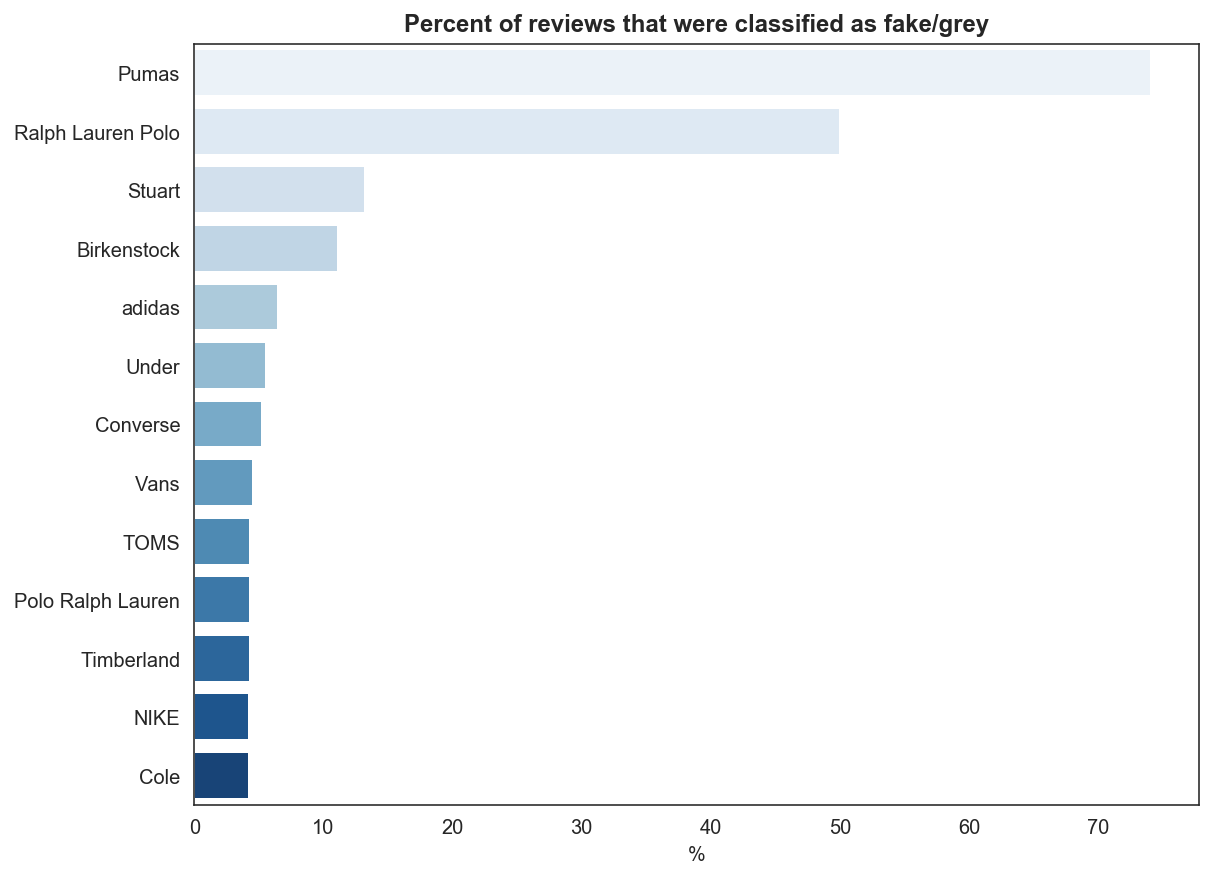

In [610]:
plt.figure(figsize=(9,7))

sns.barplot(x=df_shoe_brand[df_shoe_brand['percentage']>4]['percentage'], 
            y = df_shoe_brand[df_shoe_brand['percentage']>4]['brand'], palette='Blues')
plt.xlabel("%")
plt.title("Percent of reviews that were classified as fake/grey", fontweight='bold', fontsize=12);

plt.xlabel("%")
plt.ylabel("");

### Nike (applying model on reviews that were after original data period)

In [563]:
# sort dataframe to Nike only

df_nike = df_shoes_all[df_shoes_all['brand'] == 'NIKE'].copy()

In [564]:
df_nike['date_posted'] = pd.to_datetime(df_nike['date_posted'], infer_datetime_format=True)

In [565]:
df_nike_per = df_nike.groupby(df_nike['date_posted'].dt.to_period("M")).agg(num_reviews=('review_post_id', 'count'),
                                  num_helpful=('helpful_count', 'sum'),
                                  num_weight_fake=('weight_fake_rev','sum')).reset_index()

In [566]:
df_nike_per['percentage'] = (round(100*(df_nike_per['num_weight_fake']/
                                          (df_nike_per['num_reviews']+df_nike_per['num_helpful'])),2))

In [567]:
# percentage of reviews that mentioned fraud/fake over peeriod of time in the analysis

df_nike_per

,date_posted,num_reviews,num_helpful,num_weight_fake,percentage
0,2017-01,602,275,63.0,7.18
1,2017-02,553,257,58.0,7.16
2,2017-03,816,395,18.0,1.49
3,2017-04,746,321,59.0,5.53
4,2017-05,772,316,43.0,3.95
5,2017-06,928,373,79.0,6.07
6,2017-07,922,197,63.0,5.63
7,2017-08,1034,321,36.0,2.66
8,2017-09,968,132,34.0,3.09
9,2017-10,766,89,12.0,1.40


### Trying my model on scraped reviews 

In [587]:
# read file with reviews that I scraped to supplement my data

df_nike_new = pd.read_pickle('df_nike_new.pkl')

In [588]:
# Identify the last date in the dataset for nike reviews

df_nike['date_posted'].max()

Timestamp('2018-06-29 00:00:00')

In [590]:
# filter my scraped reviews after '2018-06-29'

df_nike_new = df_nike_new[df_nike_new['date'] > '2018-06-29'].copy()

##### Fit_transform new data to the model

For that create function

In [577]:
def FitOnTheModel(df,review_name_column, rating_name_column, column_name_helpful):
    
    """ Text preprocessing steps,
        Fit to the model,
        Label topics,
        Give weights
    """
    # text preprocessing
    
    df['review_clean'] = df[review_name_column].apply(text_cleaning) # text clean
    df['nltk_review'] = df['review_clean'].apply(nouns_adj_verbs) # pos-tag
    df_below = df[df[rating_name_column] < 4].copy() # sort for 3 and below
    
    # fit to the model
    
    global tfidf
    global topic_model
    
    review = df_below.nltk_review.to_list() # create list of reviews
    doc_word = tfidf.fit(review) # fit prev trained tfidf
    words = list(np.asarray(tfidf.get_feature_names()))
    predictions = pd.DataFrame(topic_model.transform(doc_word,details=True)[0], columns=[i for i in range(6)], 
                  index=df_below.review_name_column)
    
    # DataFrame manipulation
    
    predictions['majority'] = np.argsort(-predictions, axis=1)[0] # majority vote
    df_all = pd.merge(df, predictions, how='left', on=review_name_column)
    df_all.drop(columns=[0,1,2,3,4,5], inplace=True)
    df_all['majority'].replace({0:1,2:0,3:0,4:0,5:0}, inplace=True)
    
    df_all['majority'].fillna(0,inplace=True)
    df_all['helpful_weight'] = df_all[column_name_helpful]
    df_all['helpful_weight'].replace({0:1},inplace=True)
    df_all['weight_fake_rev'] = df_all['helpful_weight']*df_all['majority']
    
    return df_all
    

In [ ]:
# I created this function after my analysis 

In [591]:
df_nike_new['review_clean'] = df_nike_new['review_body'].apply(text_cleaning)

In [592]:
df_nike_new['nltk_review'] = df_nike_new['review_clean'].apply(nouns_adj_verbs)

In [593]:
df_nike_below = df_nike_new[df_nike_new['rating'] < 4].copy()

In [618]:
review_nike_new = df_nike_below.nltk_review.to_list()

In [619]:
doc_word = tfidf.transform(review_nike_new)

(797, 206963)

In [621]:
pr = pd.DataFrame(topic_model.transform(doc_word,details=True)[0], columns=[i for i in range(6)], 
                  index=df_nike_below.review_body)

In [623]:
pr['majority'] = np.argsort(-pr, axis=1)[0]

In [625]:
nike_test = pd.merge(df_nike_new, pr, how='left', on='review_body')

In [626]:
nike_test.drop(columns=[0,1,2,3,4,5], inplace=True)

In [627]:
nike_test.columns

Index(['name', 'review_body', 'date', 'rating', 'helpful', 'product_name',
       'review_clean', 'nltk_review', 'majority'],
      dtype='object')

In [628]:
nike_test['majority'].replace({0:1,2:0,3:0,4:0,5:0}, inplace=True)

In [629]:
nike_test['majority'].fillna(0,inplace=True)

In [630]:
nike_test['helpful_test'] = nike_test['helpful']

In [631]:
nike_test['helpful_test'].replace({0:1},inplace=True)

In [632]:
nike_test['weight_fake_rev'] = nike_test['helpful_test']*nike_test['majority']

In [394]:
test_per = nike_test.groupby(nike_test['date'].dt.to_period("M")).agg(num_reviews=('name', 'count'),
                                  num_helpful=('helpful', 'sum'),
                                  num_weight_fake=('weight_fake_rev','sum')).reset_index()

In [395]:
test_per['percentage'] = (round(100*(test_per['num_weight_fake']/
                                          (test_per['num_reviews']+test_per['num_helpful'])),2))

In [399]:
test_per.rename(columns={'date': 'date_posted'}, inplace=True)

**Results after I merged two DataFrames (original Nike data with scraped reviews data)**

In [400]:
df_all_nike_test = pd.concat([df_nike_per,test_per])

In [402]:
df_all_nike_test = df_all_nike_test.reset_index().drop(columns=['index']) 

In [413]:
df_all_nike_test['average_M'] = df_all_nike_test['percentage'].rolling(10).mean()

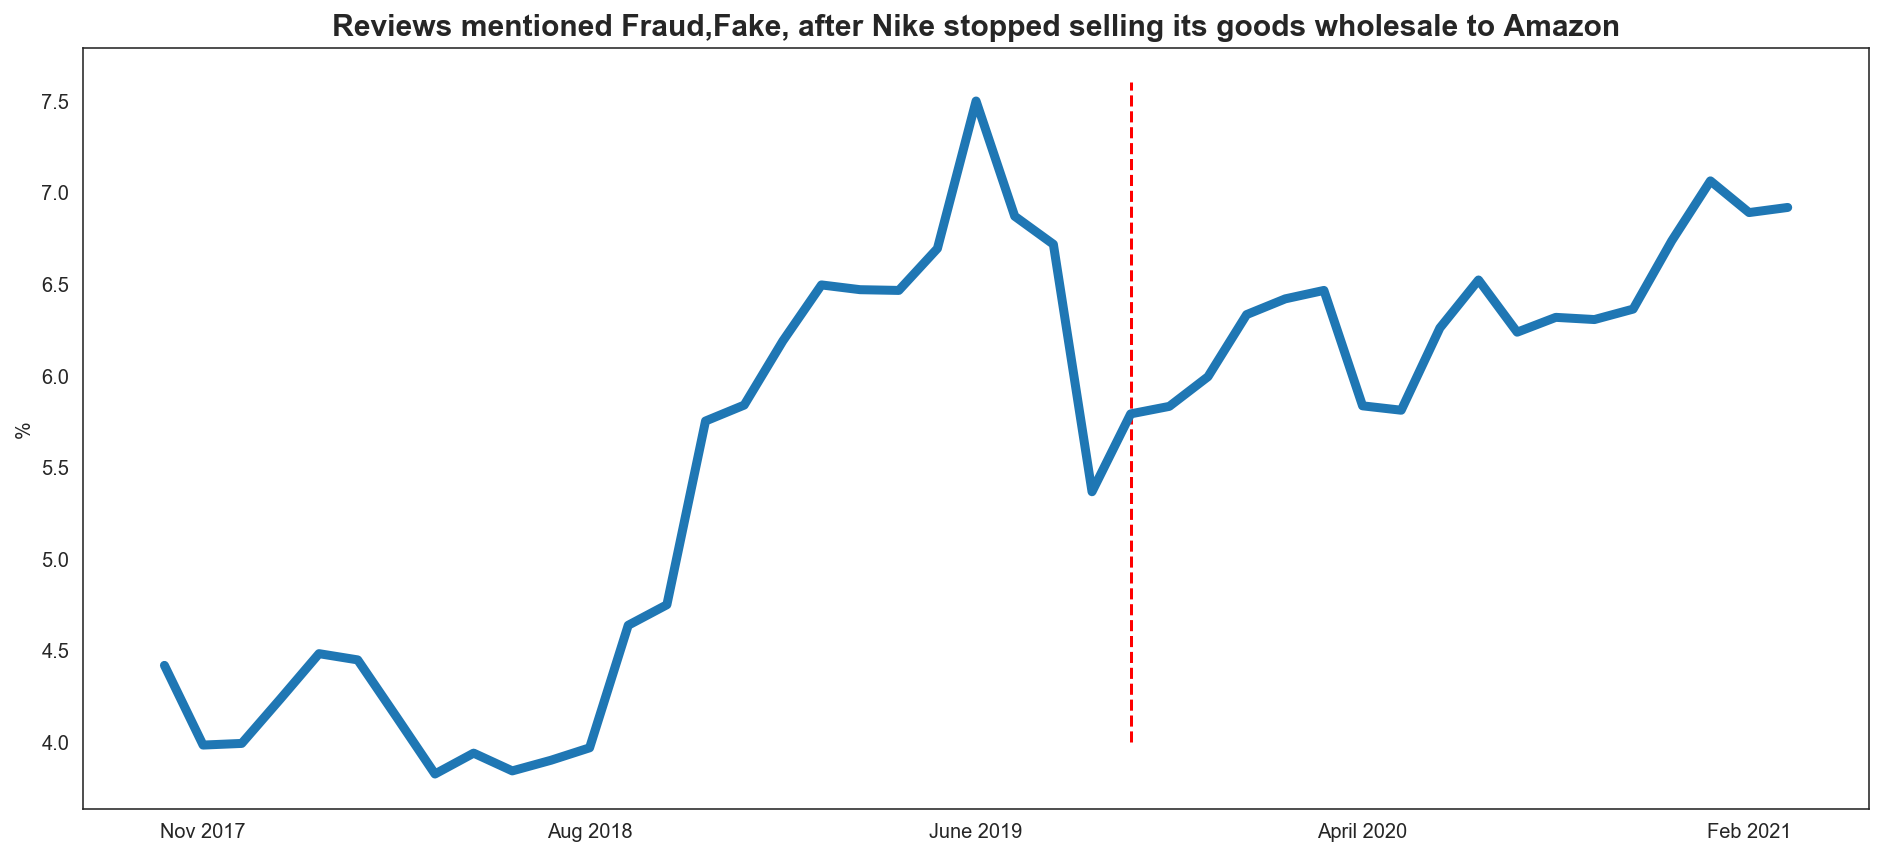

In [423]:
plt.figure(figsize=(16,7))

x,y = [34,34],[4,7.6]
plt.plot(x,y, color='red', linestyle='--')

sns.lineplot(x=df_all_nike_test.index.to_list()[5:], y='average_M', data=df_all_nike_test.loc[5:,:], palette="Blues", linewidth = 4.5)
plt.title("Reviews mentioned Fraud,Fake, after Nike stopped selling its goods wholesale to Amazon",
          fontdict={'weight': 'bold', 'size': 15})
plt.ylabel("%");
plt.xticks(ticks=[10,20,30,40,50], labels=['Nov 2017','Aug 2018','June 2019', 'April 2020', 'Feb 2021']);

#plt.savefig('img.png')

##### In November 2019, Nike stopped selling its goods wholesale to Amazon. Nike only agreed to the pilot in 2017 in exchange for Amazon policing counterfeit and third-party sales. And as we can see fraud went up and Nike decided to not continue their partnership.
